# Automation V 1.4.1: The Less Yucky Working Code
IVAR weighting works and is incorporated, dividing by slope is in 1.5 

In [64]:
import os
import numpy as np                                                             #Must normalize spectra (i.e. find median value across each spectrum, and then divide each spectrum by this value.)
from astropy.io import fits
import matplotlib.pyplot as py
from matplotlib import path
import myAstroMods as mm
import importlib as imp
from astropy.stats import sigma_clip
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
#imp.reload(mm)
%matplotlib inline

In [65]:
pathname = mm.pathname

In [66]:
# begin to read in the fits file
hdu = fits.open(os.path.join(pathname, 'subMasterSPLASH2.fits'))

In [67]:
data = hdu[1].data

In [68]:
others = np.load(os.path.join(pathname, 'indices', 'nonCarbonOrCNIndices.npy'))

allcarbon = np.load(os.path.join(pathname, 'indices', 'allCarbonIndices.npy'))
wNm = np.load(os.path.join(pathname, 'indices', 'weakCNIndices.npy'))

extremes = np.load(os.path.join(pathname, 'indices', 'extremeCarbonIndices.npy'))
strongs = np.load(os.path.join(pathname, 'indices', 'strongCarbonIndices.npy'))
mediums = np.load(os.path.join(pathname, 'indices', 'mediumCarbonIndices.npy'))
weaks = np.load(os.path.join(pathname, 'indices', 'weakCarbonIndices.npy'))
marginals = np.load(os.path.join(pathname, 'indices', 'marginalCarbonIndices.npy'))

outsiders = [i for i in range(data.size) if i not in others and i not in wNm and i not in allcarbon]


In [69]:
wNm_s_Dict1, wNm_c_Dict1 = mm.openDicts('wNm')
allC_s_Dict1, allC_c_Dict1 = mm.openDicts('allC')
others_s_Dict, others_c_Dict = mm.openDicts('others')

In [70]:
lowerThresh = 5850
upperThresh = 6550
window = 25


In [71]:
wv = data['LBIN'][0][lowerThresh:upperThresh]
gauss = Gaussian1DKernel(1.5)


In [72]:
# we compare only within a certain threshold because tends to be noise on on far left and right
def normalizeSpec(starSpec):
    #we don't want the starSpec to have no nan values because they act as placeholders
    #assign a different variable  to the spectra without nan
    diffSpec = starSpec[~np.isnan(starSpec)] 
    nor = 1 / np.median(diffSpec)
    return nor*starSpec

In [73]:
clipspecC = mm.infWAvCoadd(data, allcarbon)
CtempSpec = normalizeSpec(clipspecC[lowerThresh:upperThresh])

In [74]:
clipspecWCN = mm.infWAvCoadd(data, wNm)
WtempSpec = clipspecWCN
smoothSpecWCN = convolve(WtempSpec, gauss)
'''py.rcParams['figure.figsize'] = 25,15
py.ylim(0,1.5)
py.plot(wv, smoothSpecWCN)'''

"py.rcParams['figure.figsize'] = 25,15\npy.ylim(0,1.5)\npy.plot(wv, smoothSpecWCN)"

In [75]:
m = (19 - -52.965)/(2.03045-10) # Slope of Phil's line, derived from the two points on A^3's plot
xPhil = np.arange(1, 3, .01)
yPhil = m*xPhil - 2.0345*m + 19 

THE MORE UPDATED FUNCTIONS BELOW

adjusting template spectrum

In [76]:
# we compare only within a certain threshold because tends to be noise on on far left and right
def normalizeStar(testStar, lowerT = lowerThresh, upperT = upperThresh):
    starSpec = data['SPEC'][testStar][lowerT:upperT]
    #we don't want the starSpec to have no nan values because they act as placeholders
    #assign a different variable  to the spectra without nan
    diffSpec = starSpec[~np.isnan(starSpec)] 
    nor = 1 / np.median(diffSpec)
    ivar = data['IVAR'][testStar][lowerT:upperT] * 1/nor**2
    return nor*starSpec, ivar

In [77]:
def getScore(spec, testStar):
    testSpec, ivar = normalizeStar(testStar)
    sq_diff = np.square(np.subtract(testSpec, spec))
    weighted_diff = sq_diff*ivar
    div = len(testSpec[~np.isnan(testSpec)])
    total = np.nansum(weighted_diff)/div
    total = np.sqrt(total)
    return total

In [78]:
def getSlope(starSpec, norm = False):
    lowerInt = starSpec[lowerThresh-window:lowerThresh+window]
    upperInt = starSpec[upperThresh-window:upperThresh+window]
    lowMedian = np.median(lowerInt[~np.isnan(lowerInt)])
    upMedian = np.median(upperInt[~np.isnan(upperInt)])
    slope = (upMedian - lowMedian)/(data['LBIN'][0][upperThresh] - data['LBIN'][0][lowerThresh])
    if norm:
        spec = starSpec[lowerThresh:upperThresh]
        diffSpec = spec[~np.isnan(spec)] 
        nor = 1 / np.median(diffSpec)
        return nor*slope
    else:
        return slope
    
def getSlopeNorm(starSpec):
    lowerInt = starSpec[:window]
    upperInt = starSpec[-window:]
    lowMedian = np.median(lowerInt[~np.isnan(lowerInt)])
    upMedian = np.median(upperInt[~np.isnan(upperInt)])
    slope = (upMedian - lowMedian)/(data['LBIN'][0][upperThresh] - data['LBIN'][0][lowerThresh])
    return slope

In [79]:

def Crange(start, stop, step, zoomStart = None, zoomStop = None, zoomStep = None):
    ranger = []
    i = start
    if zoomStart == None:
        zoomStart =  start 
        zoomStop = stop
        zoomStep = step
    while i < stop:
        ranger.append(i)
        if i >= zoomStart and i <= zoomStop:
            i += zoomStep 
        else:
            i += step
    return ranger

In [80]:
def getTiltedSpec(s, spec):
    deltaLam = wv - data['LBIN'][0][lowerThresh]
    tilted = s*deltaLam + spec
    tilted = tilted/np.median(tilted)
    return tilted

def getScaledSpec(c):
    if c == -1:
        return None
    scaledSpec = (CtempSpec + c)/(1+c)
    return scaledSpec

def findOptimalC(testStar, lowC = -10, highC = 40, step = 0.01, zoomStart = None, zoomStop = None, zoomStep = None):
    bestScore = 1000000
    bestC, bestS = 0, 0
    slope = getSlope(data['SPEC'][testStar], True)
    for c in Crange(lowC, highC, step, zoomStart, zoomStop, zoomStep):
        if c == -1:
            continue
        scaledSpec = getScaledSpec(c)
        s = slope - getSlopeNorm(scaledSpec)
        tiltedSpec = getTiltedSpec(s, scaledSpec)
        testScore = getScore(tiltedSpec, testStar)
        if testScore < bestScore:
            bestC, bestS = c, s
            bestScore = testScore
                               
    return bestC, bestS, bestScore
                               

## Finding  best C and S for each group of stars

In [81]:
#WEAK AND MARGINAl
wNm_c_Dict, wNm_s_Dict, wNm_score_Dict = {}, {}, {}
counter = 0
for star in wNm:
    counter += 1
    wNm_c_Dict[star], wNm_s_Dict[star], wNm_score_Dict[star] = findOptimalC(star, lowC = -30, highC = 60, step = 0.5, zoomStart = -5, zoomStop = 8, zoomStep = 0.01)
    if counter%10 == 0:
        print(str(counter)+' done')

10 done
20 done
30 done
40 done
50 done
60 done
70 done
80 done
90 done
100 done
110 done
120 done
130 done
140 done
150 done


In [82]:
#CARBON STARS
allC_c_Dict, allC_s_Dict, allC_score_Dict = {}, {}, {}
counter = 0
for star in allcarbon:
    counter += 1
    allC_c_Dict[star], allC_s_Dict[star], allC_score_Dict[star] = findOptimalC(star, lowC = -30, highC = 60, step = 0.5, zoomStart = -5, zoomStop = 8, zoomStep = 0.01)
    if counter%10 == 0:
        print(str(counter)+' done')

10 done
20 done
30 done
40 done


/Users/Chinthan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


50 done
60 done
70 done
80 done
90 done


In [83]:
bright = [i for i in others if data['F814W'][i] < 21]
print(len(bright))

3170


In [84]:
#ALL BRIGHT STARS
bright_c_Dict, bright_s_Dict, bright_score_Dict = {}, {}, {}
counter = 0
for star in bright:
    counter += 1
    bright_c_Dict[star], bright_s_Dict[star], bright_score_Dict[star] = findOptimalC(star, lowC = -30, highC = 60, step = 0.5, zoomStart = -5, zoomStop = 8, zoomStep = 0.01)
    if counter%10 == 0:
        print(str(counter)+' done')

10 done
20 done
30 done
40 done
50 done
60 done
70 done
80 done
90 done
100 done
110 done
120 done
130 done
140 done
150 done
160 done
170 done
180 done
190 done
200 done
210 done
220 done
230 done
240 done
250 done
260 done
270 done
280 done
290 done
300 done
310 done
320 done
330 done
340 done
350 done
360 done
370 done
380 done
390 done
400 done
410 done
420 done
430 done
440 done
450 done
460 done
470 done
480 done
490 done
500 done
510 done
520 done
530 done
540 done
550 done
560 done
570 done
580 done
590 done
600 done
610 done
620 done
630 done
640 done
650 done
660 done
670 done
680 done
690 done
700 done
710 done
720 done
730 done
740 done
750 done
760 done
770 done
780 done
790 done
800 done
810 done
820 done
830 done
840 done
850 done
860 done
870 done
880 done
890 done
900 done
910 done
920 done
930 done
940 done
950 done
960 done
970 done
980 done
990 done
1000 done
1010 done
1020 done
1030 done
1040 done
1050 done
1060 done
1070 done
1080 done
1090 done
1100 done
1110 don

/Users/Chinthan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in divide
/Users/Chinthan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/Users/Chinthan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide
/Users/Chinthan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in multiply


1660 done
1670 done
1680 done
1690 done
1700 done
1710 done
1720 done
1730 done
1740 done
1750 done
1760 done
1770 done
1780 done
1790 done
1800 done
1810 done
1820 done
1830 done
1840 done
1850 done
1860 done
1870 done
1880 done
1890 done
1900 done
1910 done
1920 done
1930 done
1940 done
1950 done
1960 done
1970 done
1980 done
1990 done
2000 done
2010 done
2020 done
2030 done
2040 done
2050 done
2060 done
2070 done
2080 done
2090 done
2100 done
2110 done
2120 done
2130 done
2140 done
2150 done
2160 done
2170 done
2180 done
2190 done
2200 done
2210 done
2220 done
2230 done
2240 done
2250 done
2260 done
2270 done
2280 done
2290 done
2300 done
2310 done
2320 done
2330 done
2340 done
2350 done
2360 done
2370 done
2380 done
2390 done
2400 done
2410 done
2420 done
2430 done
2440 done
2450 done
2460 done
2470 done
2480 done
2490 done
2500 done
2510 done
2520 done
2530 done
2540 done
2550 done
2560 done
2570 done
2580 done
2590 done
2600 done
2610 done
2620 done
2630 done
2640 done
2650 done


In [105]:
#ALL OTHER STARS
others_c_Dict, others_s_Dict, others_score_Dict = {}, {}, {}
counter = 0
for star in others:
    counter += 1
    others_c_Dict[star], others_s_Dict[star], others_score_Dict[star] = findOptimalC(star, lowC = -30, highC = 60, step = 0.5, zoomStart = -5, zoomStop = 8, zoomStep = 0.01)
    if counter % 10 == 0:
        print(str(counter)+' done')

10 done
20 done
30 done
40 done
50 done
60 done
70 done
80 done
90 done
100 done
110 done
120 done
130 done
140 done
150 done
160 done
170 done
180 done
190 done
200 done
210 done
220 done
230 done
240 done
250 done
260 done
270 done
280 done
290 done
300 done
310 done
320 done
330 done
340 done
350 done
360 done
370 done
380 done
390 done
400 done
410 done
420 done
430 done
440 done
450 done
460 done
470 done
480 done
490 done
500 done
510 done
520 done
530 done
540 done
550 done
560 done
570 done
580 done
590 done
600 done
610 done
620 done
630 done
640 done
650 done
660 done
670 done
680 done
690 done
700 done
710 done
720 done
730 done
740 done
750 done
760 done
770 done
780 done
790 done
800 done
810 done
820 done
830 done
840 done
850 done
860 done
870 done
880 done
890 done
900 done
910 done
920 done
930 done
940 done
950 done
960 done
970 done
980 done
990 done
1000 done
1010 done
1020 done
1030 done
1040 done
1050 done
1060 done
1070 done
1080 done
1090 done
1100 done
1110 don

/Users/Chinthan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in divide
/Users/Chinthan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/Users/Chinthan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide
/Users/Chinthan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in multiply


1830 done
1840 done
1850 done
1860 done
1870 done
1880 done
1890 done
1900 done
1910 done
1920 done
1930 done
1940 done
1950 done
1960 done
1970 done
1980 done
1990 done
2000 done
2010 done
2020 done
2030 done
2040 done
2050 done
2060 done
2070 done
2080 done
2090 done
2100 done
2110 done
2120 done
2130 done
2140 done
2150 done
2160 done
2170 done
2180 done
2190 done
2200 done
2210 done
2220 done
2230 done
2240 done
2250 done
2260 done
2270 done
2280 done
2290 done
2300 done
2310 done
2320 done
2330 done
2340 done
2350 done
2360 done
2370 done
2380 done
2390 done
2400 done
2410 done
2420 done
2430 done
2440 done
2450 done
2460 done
2470 done
2480 done
2490 done
2500 done
2510 done
2520 done
2530 done
2540 done
2550 done
2560 done
2570 done
2580 done
2590 done
2600 done
2610 done
2620 done
2630 done
2640 done
2650 done
2660 done
2670 done
2680 done
2690 done
2700 done
2710 done
2720 done
2730 done
2740 done
2750 done
2760 done
2770 done
2780 done
2790 done
2800 done
2810 done
2820 done


/Users/Chinthan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


3330 done
3340 done
3350 done
3360 done
3370 done
3380 done
3390 done
3400 done
3410 done
3420 done
3430 done
3440 done
3450 done
3460 done
3470 done
3480 done
3490 done
3500 done
3510 done
3520 done
3530 done
3540 done
3550 done
3560 done
3570 done
3580 done
3590 done
3600 done
3610 done
3620 done
3630 done
3640 done
3650 done
3660 done
3670 done
3680 done
3690 done
3700 done
3710 done
3720 done
3730 done
3740 done
3750 done
3760 done
3770 done
3780 done
3790 done
3800 done
3810 done
3820 done
3830 done
3840 done
3850 done
3860 done
3870 done
3880 done
3890 done
3900 done
3910 done
3920 done
3930 done
3940 done
3950 done
3960 done
3970 done
3980 done
3990 done
4000 done
4010 done
4020 done
4030 done
4040 done
4050 done
4060 done
4070 done
4080 done
4090 done
4100 done
4110 done
4120 done
4130 done
4140 done
4150 done
4160 done
4170 done
4180 done
4190 done
4200 done
4210 done
4220 done
4230 done
4240 done
4250 done
4260 done
4270 done
4280 done
4290 done
4300 done


/Users/Chinthan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars


4310 done
4320 done
4330 done
4340 done
4350 done
4360 done
4370 done
4380 done
4390 done
4400 done
4410 done
4420 done
4430 done
4440 done
4450 done
4460 done
4470 done
4480 done
4490 done
4500 done
4510 done
4520 done
4530 done
4540 done
4550 done
4560 done
4570 done
4580 done
4590 done
4600 done
4610 done
4620 done
4630 done
4640 done
4650 done
4660 done
4670 done
4680 done
4690 done
4700 done
4710 done
4720 done
4730 done
4740 done
4750 done
4760 done
4770 done
4780 done
4790 done
4800 done
4810 done
4820 done
4830 done
4840 done
4850 done
4860 done
4870 done
4880 done
4890 done
4900 done
4910 done
4920 done
4930 done
4940 done
4950 done
4960 done
4970 done
4980 done
4990 done
5000 done
5010 done
5020 done
5030 done
5040 done
5050 done
5060 done
5070 done
5080 done
5090 done
5100 done
5110 done
5120 done
5130 done
5140 done
5150 done
5160 done
5170 done
5180 done
5190 done
5200 done
5210 done
5220 done
5230 done
5240 done
5250 done
5260 done
5270 done
5280 done
5290 done
5300 done


('Scale Factor: ', -9.0)
('Slope: ', 0.0021641189645566898)


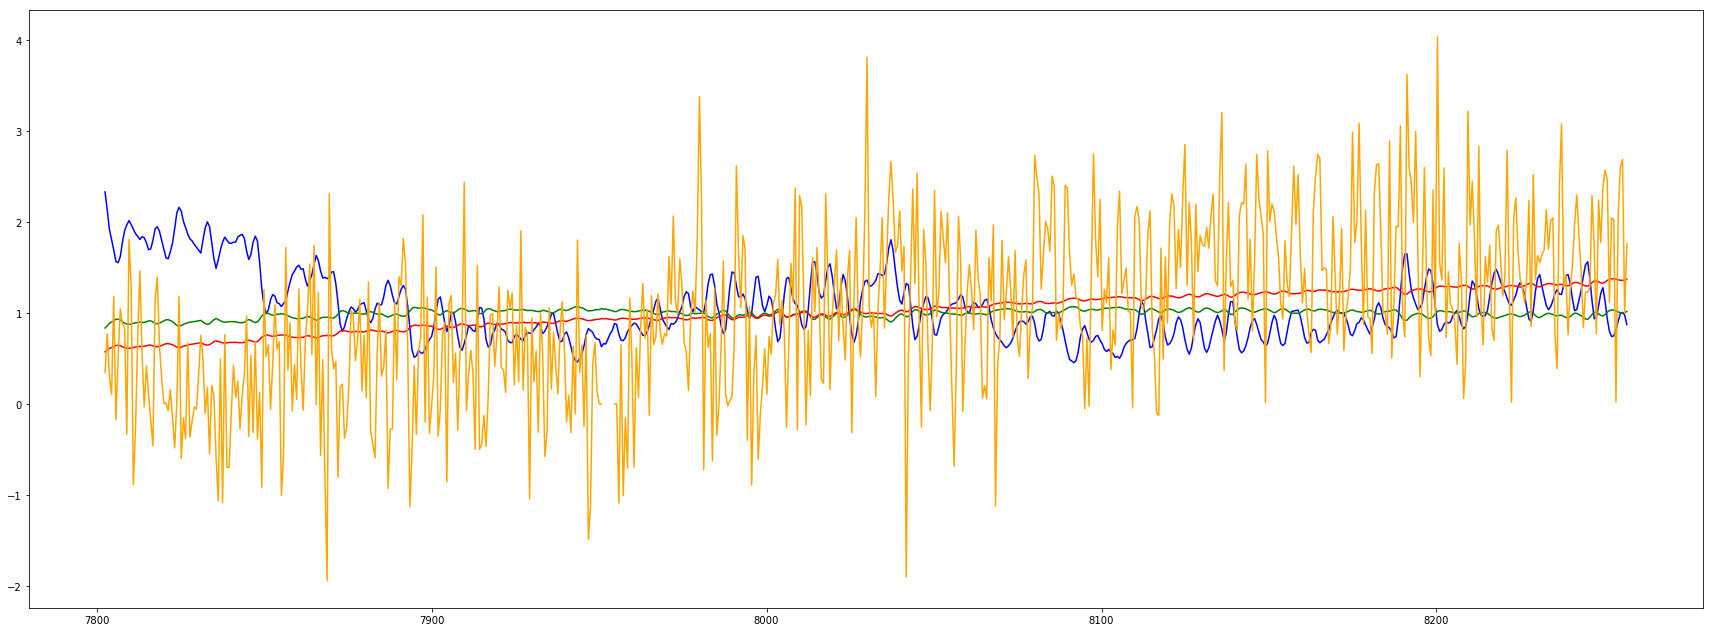

In [106]:
num = 90
scaled = getScaledSpec(bright_c_Dict[bright[num]])
tilted = getTiltedSpec(bright_s_Dict[bright[num]], scaled)

py.rcParams['figure.figsize'] = 30,11

py.plot(wv, CtempSpec, color = "b")
py.plot(wv, scaled, color = 'g')
py.plot(wv, tilted, color = 'r')
py.plot(wv, normalizeSpec(data['SPEC'][bright[num]][lowerThresh:upperThresh]), color ='orange')

print("Scale Factor: ", bright_c_Dict[bright[num]])
print("Slope: ", bright_s_Dict[bright[num]])

In [107]:
def findScore(star, SDict, CDict):
    scaled = getScaledSpec(CDict[star])
    tilted = getTiltedSpec(SDict[star], scaled)
    score = getScore(tilted, star)
    return score

In [108]:
wNm_score_Dict = {}
for i in wNm:
    wNm_score_Dict[i] = findScore(i, wNm_s_Dict, wNm_c_Dict)

In [109]:
allC_score_Dict = {}
for i in allcarbon:
    allC_score_Dict[i] = findScore(i, allC_s_Dict, allC_c_Dict)

/Users/Chinthan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


In [110]:
others_score_Dict = {}
for i in others:
    others_score_Dict[i] = findScore(i, others_s_Dict, others_c_Dict)

/Users/Chinthan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/Users/Chinthan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide
/Users/Chinthan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in multiply
/Users/Chinthan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


In [111]:
def SCLists(indices, Sdict, Cdict, scoreDict):
    Slist, Clist, scoreList = [], [], []
    for i in indices:
        Slist.append(Sdict[i])
        Clist.append(Cdict[i])
        scoreList.append(scoreDict[i])

    return Slist, Clist, scoreList



In [112]:
Slist_wNm, Clist_wNm, scoreList_wNm = SCLists(wNm, wNm_s_Dict, wNm_c_Dict, wNm_score_Dict)

Slist_allC, Clist_allC, scoreList_allC = SCLists(allcarbon, allC_s_Dict, allC_c_Dict, allC_score_Dict)

#Slist_others, Clist_others, scoreList_others = SCLists(others, others_s_Dict, others_c_Dict,  others_score_Dict)

Slist_bright, Clist_bright, scoreList_bright = SCLists(bright[:276], bright_s_Dict, bright_c_Dict, bright_score_Dict)

this next cell is a plot for C vs S for all stars, weak CN is blue, carbon is green, others are black

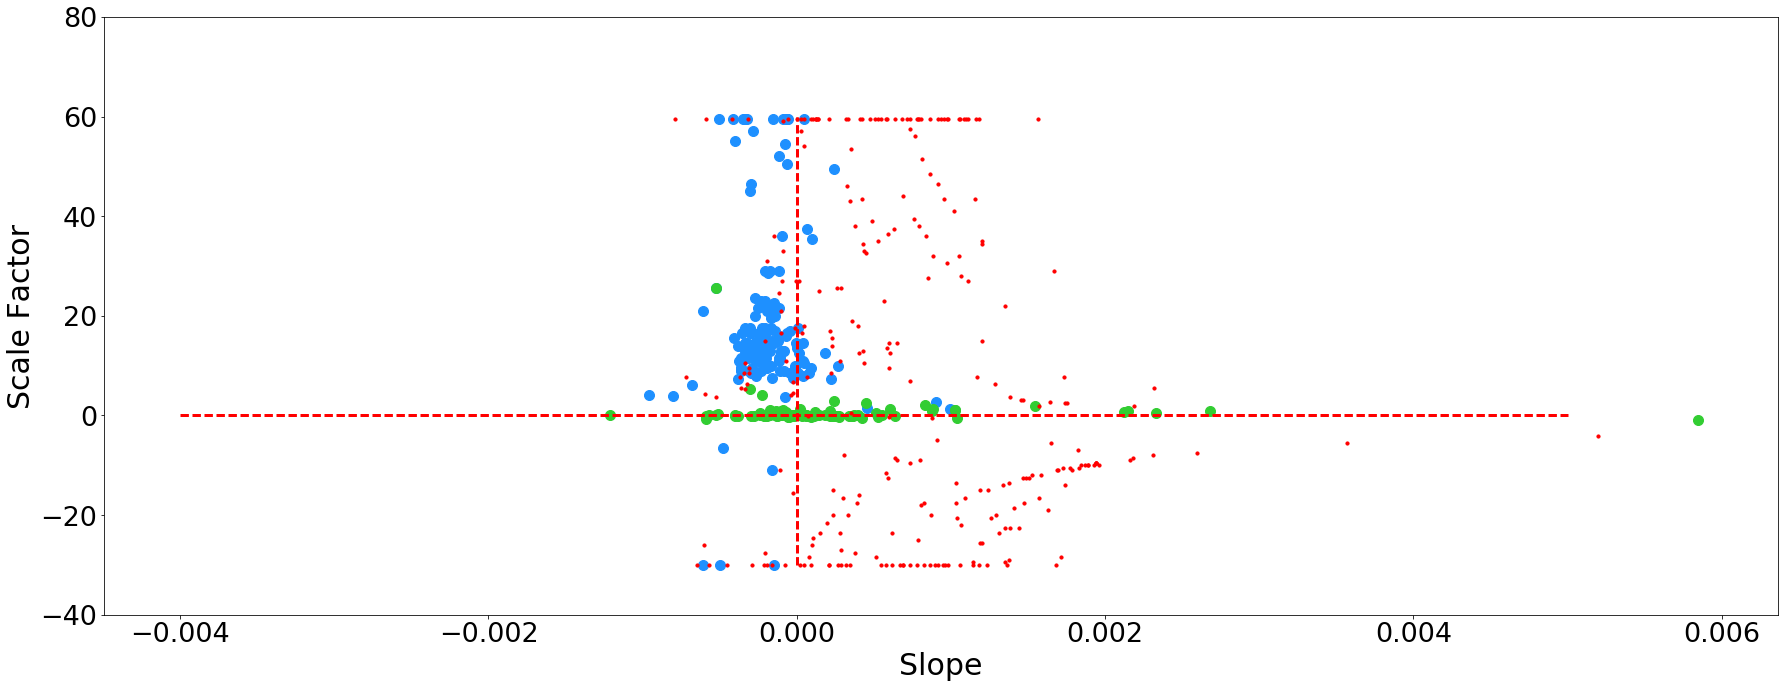

In [113]:
SCfig = py.figure()
SCAx = SCfig.add_subplot(111)
py.rcParams['figure.figsize'] = 30,21
#py.scatter(scoreList_others, Clist_others, color = 'k', s = 1)
py.scatter(Slist_wNm, Clist_wNm, color = "dodgerblue", s= 100)
py.scatter(Slist_allC, Clist_allC, color = 'limegreen', s = 100)
py.scatter(Slist_bright, Clist_bright, color = 'red', s = 10)


#py.xlim(0,5)
py.ylim(-40, 80)

#py.plot([0.000565, 0.000565],[-100, 150], linewidth = 3, linestyle = '--', color= 'red')

py.plot([-0.004, 0.005],[0, 0], linewidth = 3, linestyle = '--', color = 'red')
py.plot([0, 0],[-30, 60], linewidth = 3, linestyle = '--', color = 'red')

py.xlabel('Slope', size = 30)
py.ylabel('Scale Factor', size =30)
py.tick_params(axis='x', labelsize=27)
py.tick_params(axis='y', labelsize=27)



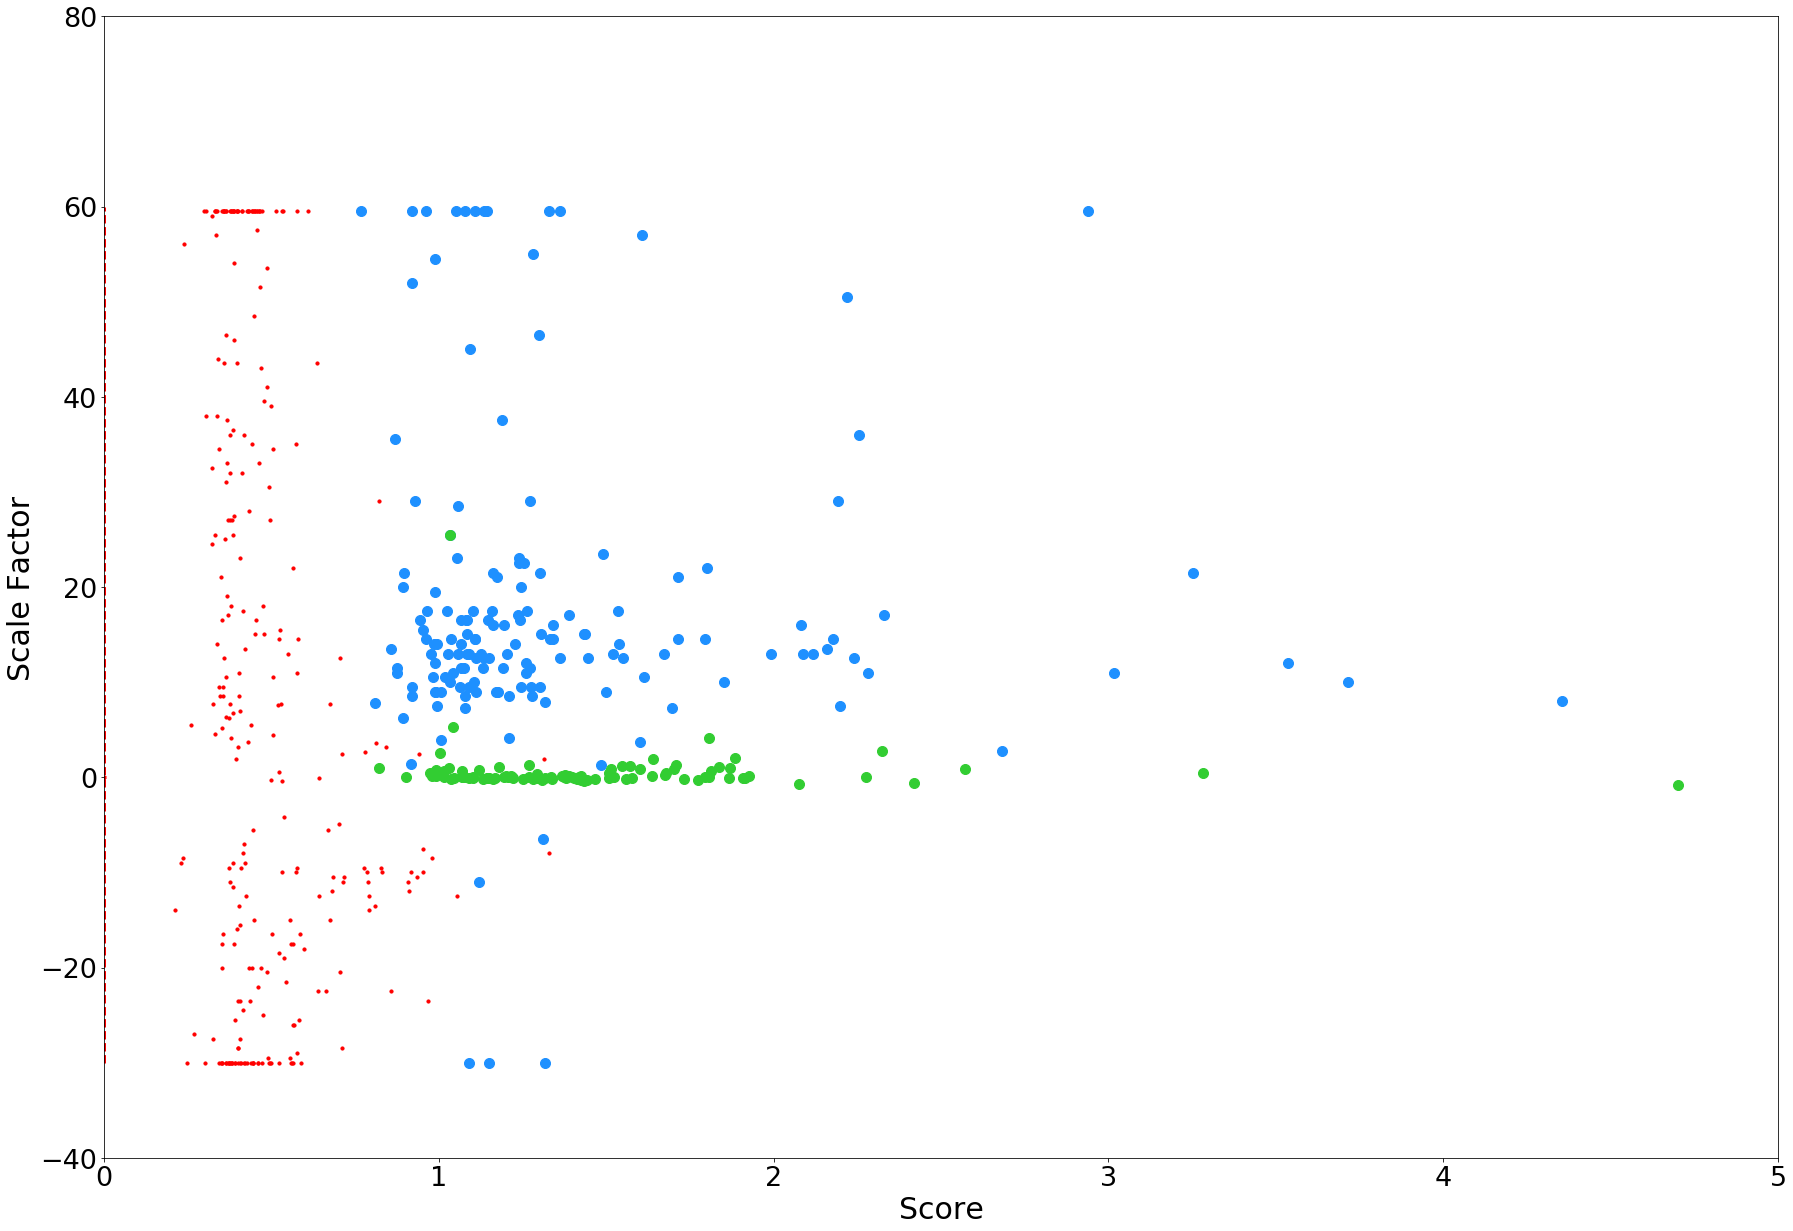

In [114]:
SCfig = py.figure()
SCAx = SCfig.add_subplot(111)
py.rcParams['figure.figsize'] = 30,21
py.scatter(scoreList_wNm, Clist_wNm, color = "dodgerblue", s= 100)
py.scatter(scoreList_allC, Clist_allC, color = 'limegreen', s = 100)
py.scatter(scoreList_bright, Clist_bright, color = 'red', s = 10)


py.xlim(0,5)
py.ylim(-40, 80)

#py.plot([0.000565, 0.000565],[-100, 150], linewidth = 3, linestyle = '--', color= 'red')

py.plot([-0.004, 0.005],[0, 0], linewidth = 3, linestyle = '--', color = 'red')
py.plot([0, 0],[-30, 60], linewidth = 3, linestyle = '--', color = 'red')

py.xlabel('Score', size = 30)
py.ylabel('Scale Factor', size =30)
py.tick_params(axis='x', labelsize=27)
py.tick_params(axis='y', labelsize=27)




In [115]:
high_weaks = [i for i in wNm if wNm_c_Dict[i] > 50]

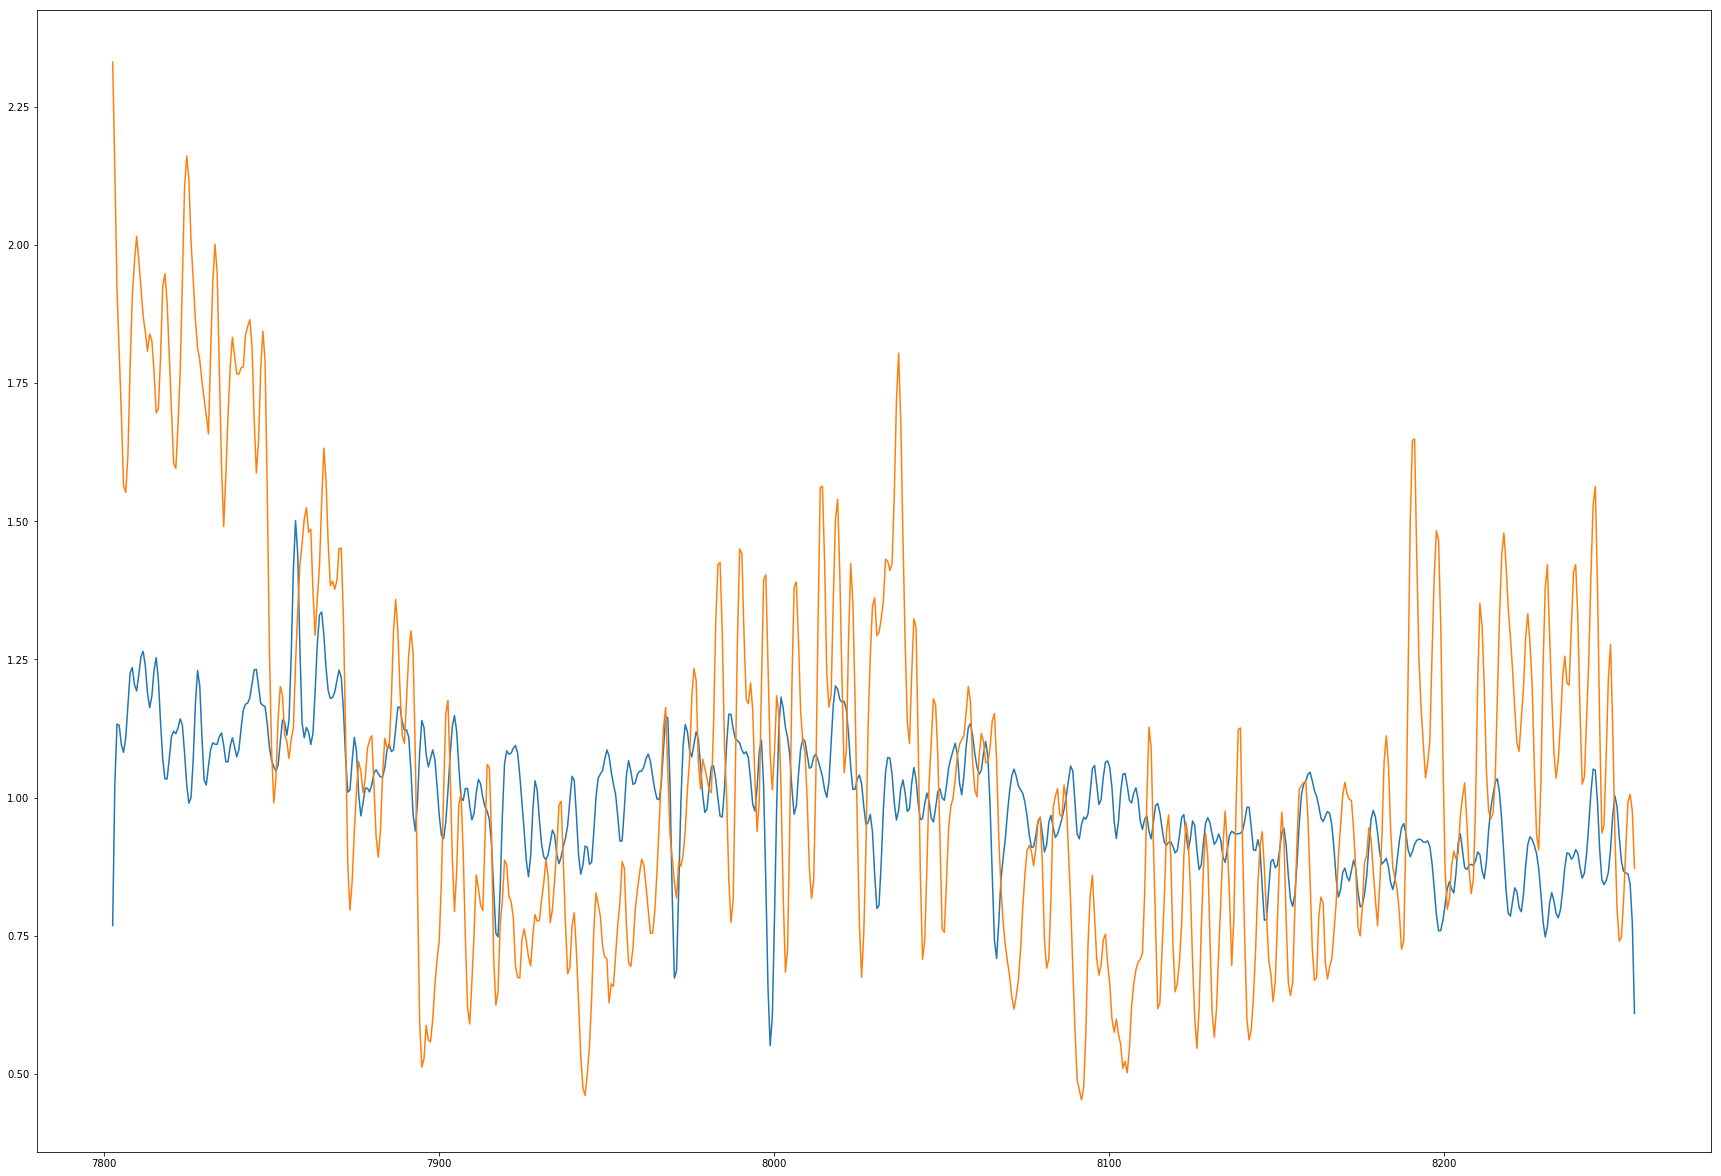

In [116]:
spec, eyevar = normalizeStar(high_weaks[1])
py.plot(wv, convolve(spec, gauss))
py.plot(wv, CtempSpec)


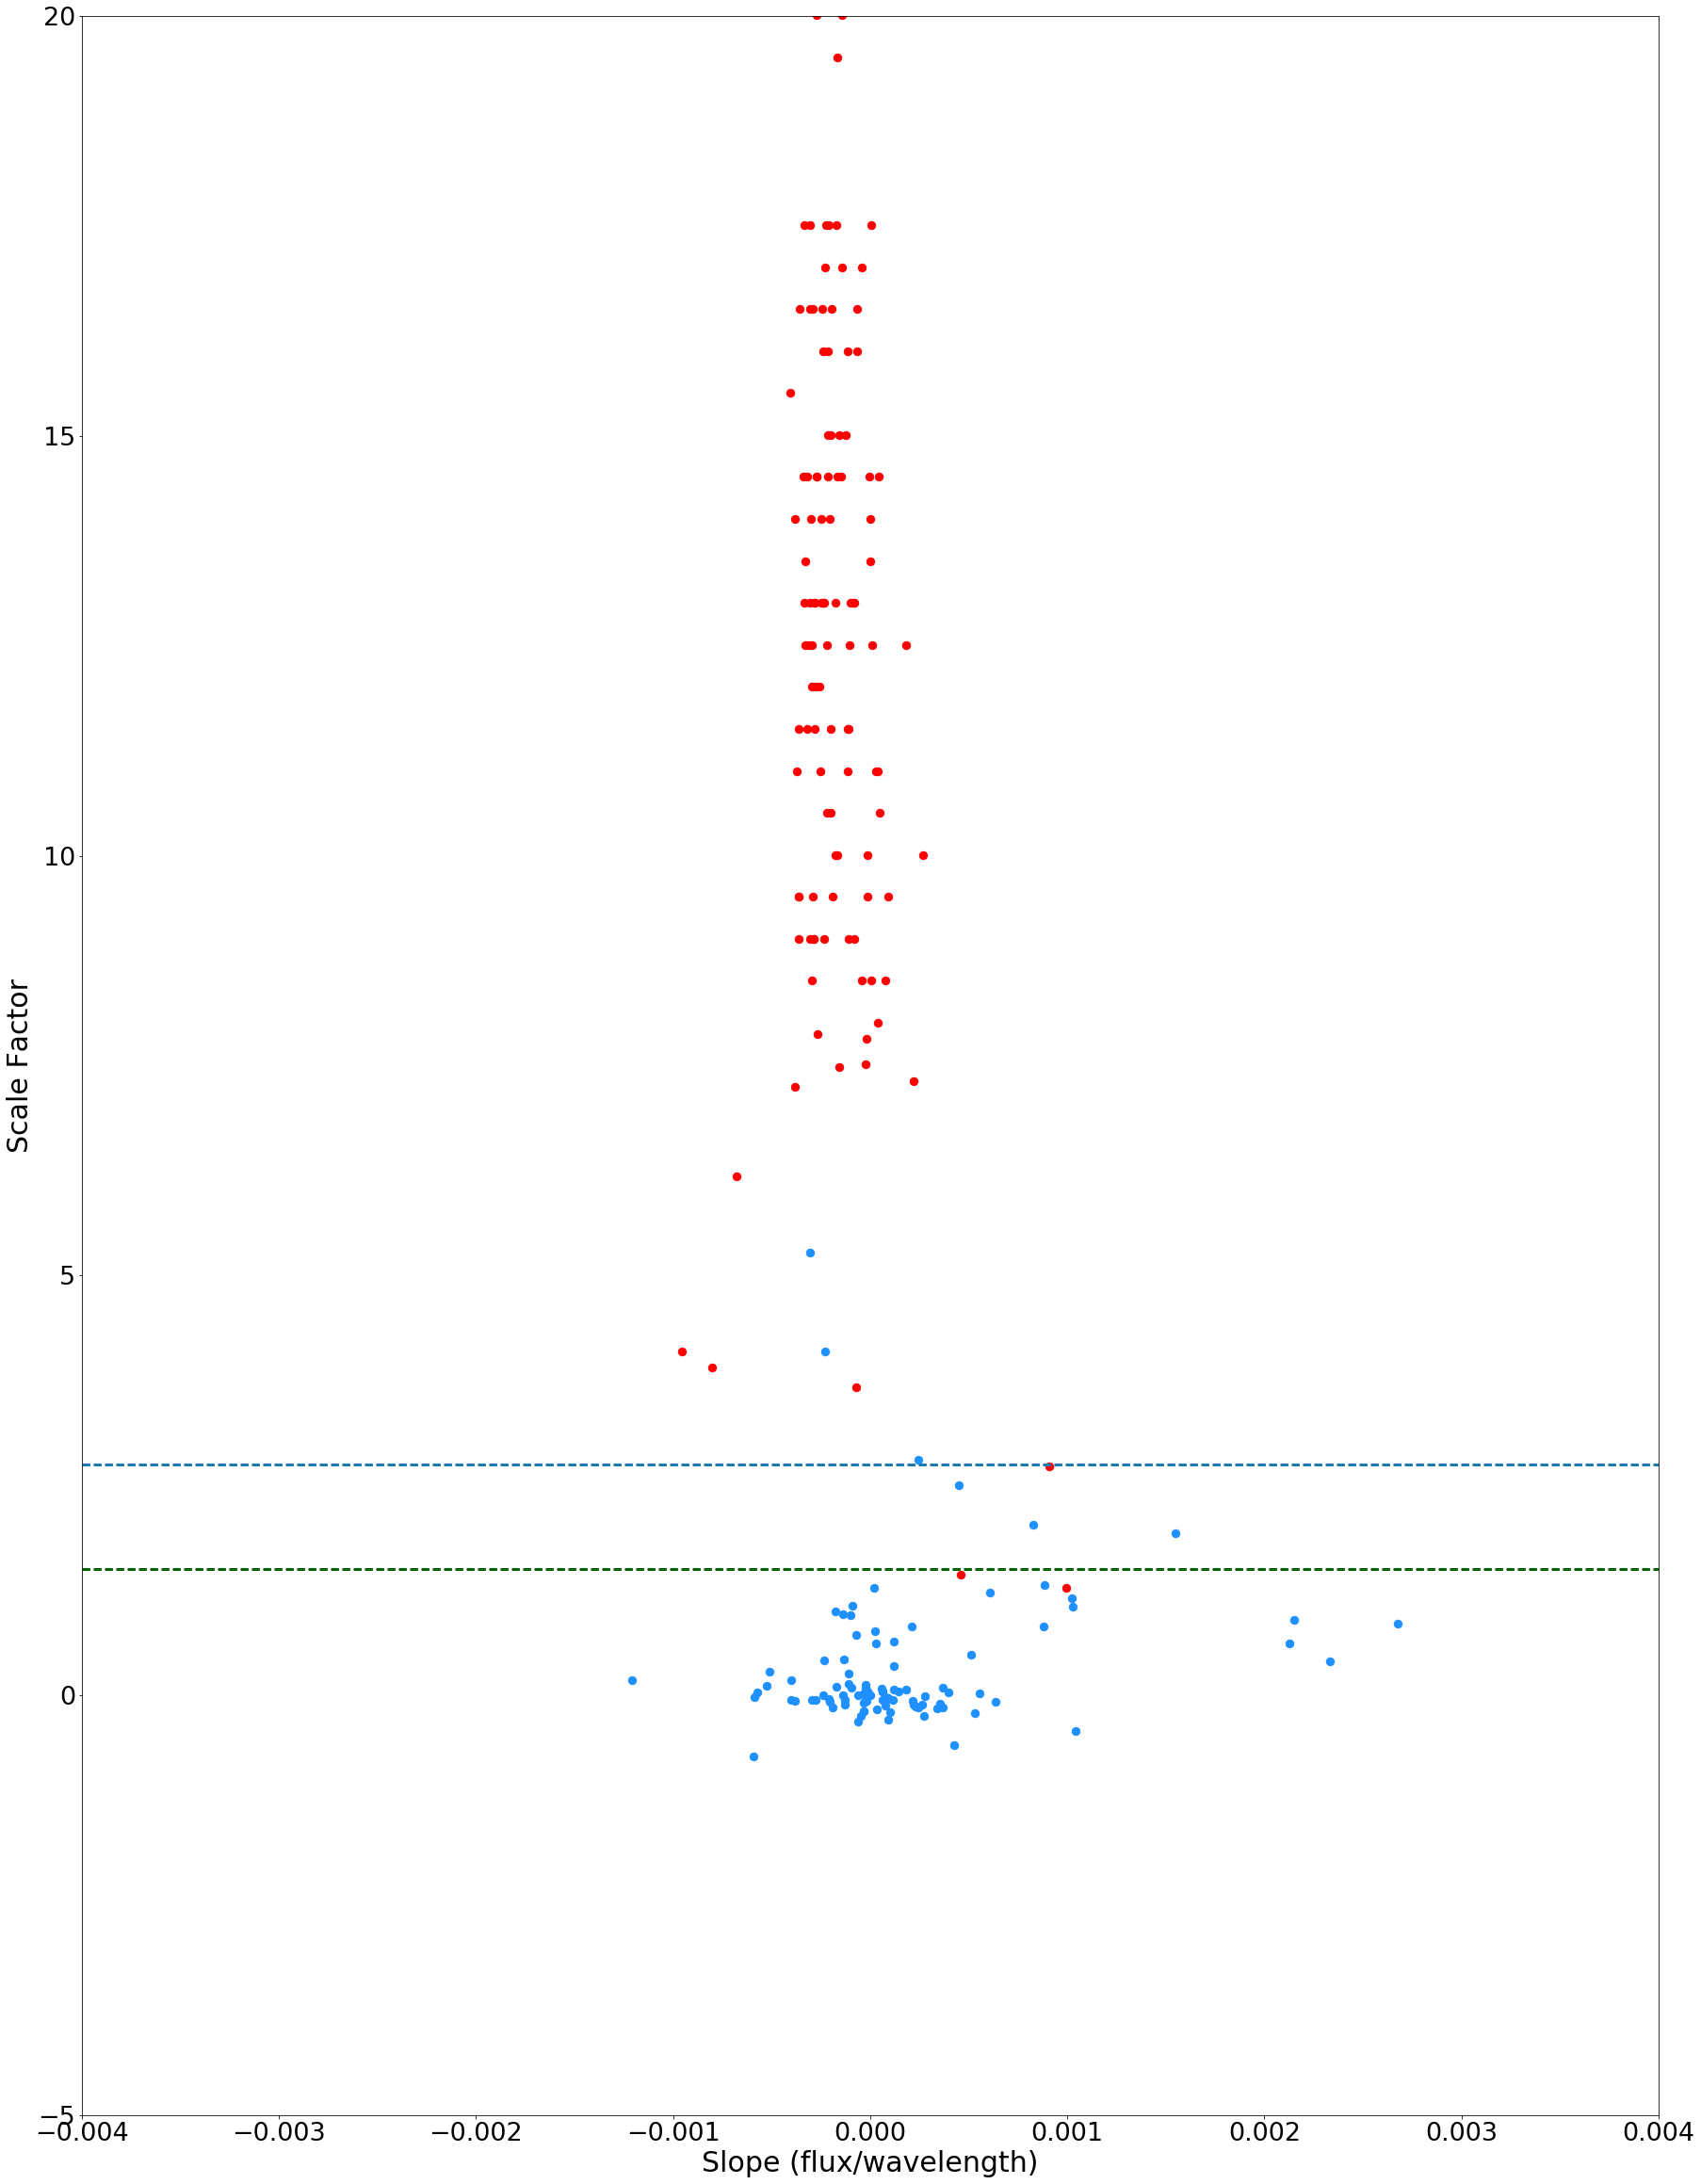

In [117]:
py.rcParams['figure.figsize'] = 30,41
py.scatter(Slist_wNm, Clist_wNm, color = 'red', s= 70)
py.scatter(Slist_allC, Clist_allC, color = 'dodgerblue', s=70)


py.xlim(-0.004, 0.004)
py.ylim(-5, 20)

py.plot([-0.004, 0.004],[2.75, 2.75], linewidth = 3, linestyle = '--')
py.plot([-0.004, 0.004],[1.5, 1.5], linewidth = 3, linestyle = '--', color = 'darkgreen')

py.xlabel('Slope (flux/wavelength)', size = 30)
py.ylabel('Scale Factor', size =30)
py.tick_params(axis='x', labelsize=27)
py.tick_params(axis='y', labelsize=27)

quadrants below are arbitrary, just something i was trying

In [118]:
oQ1 = [i for i in others if others_s_Dict[i] > 0.000565 and others_c_Dict[i] > -1.25]
oQ2 = [i for i in others if others_s_Dict[i] < 0.000565 and others_c_Dict[i] > -1.25]
oQ3 = [i for i in others if others_s_Dict[i] < 0.000565 and others_c_Dict[i] < -1.25]
oQ4 = [i for i in others if others_s_Dict[i] > 0.000565 and others_c_Dict[i] < -1.25]

In [119]:
top = oQ1 + oQ2
bottom = oQ3 + oQ4

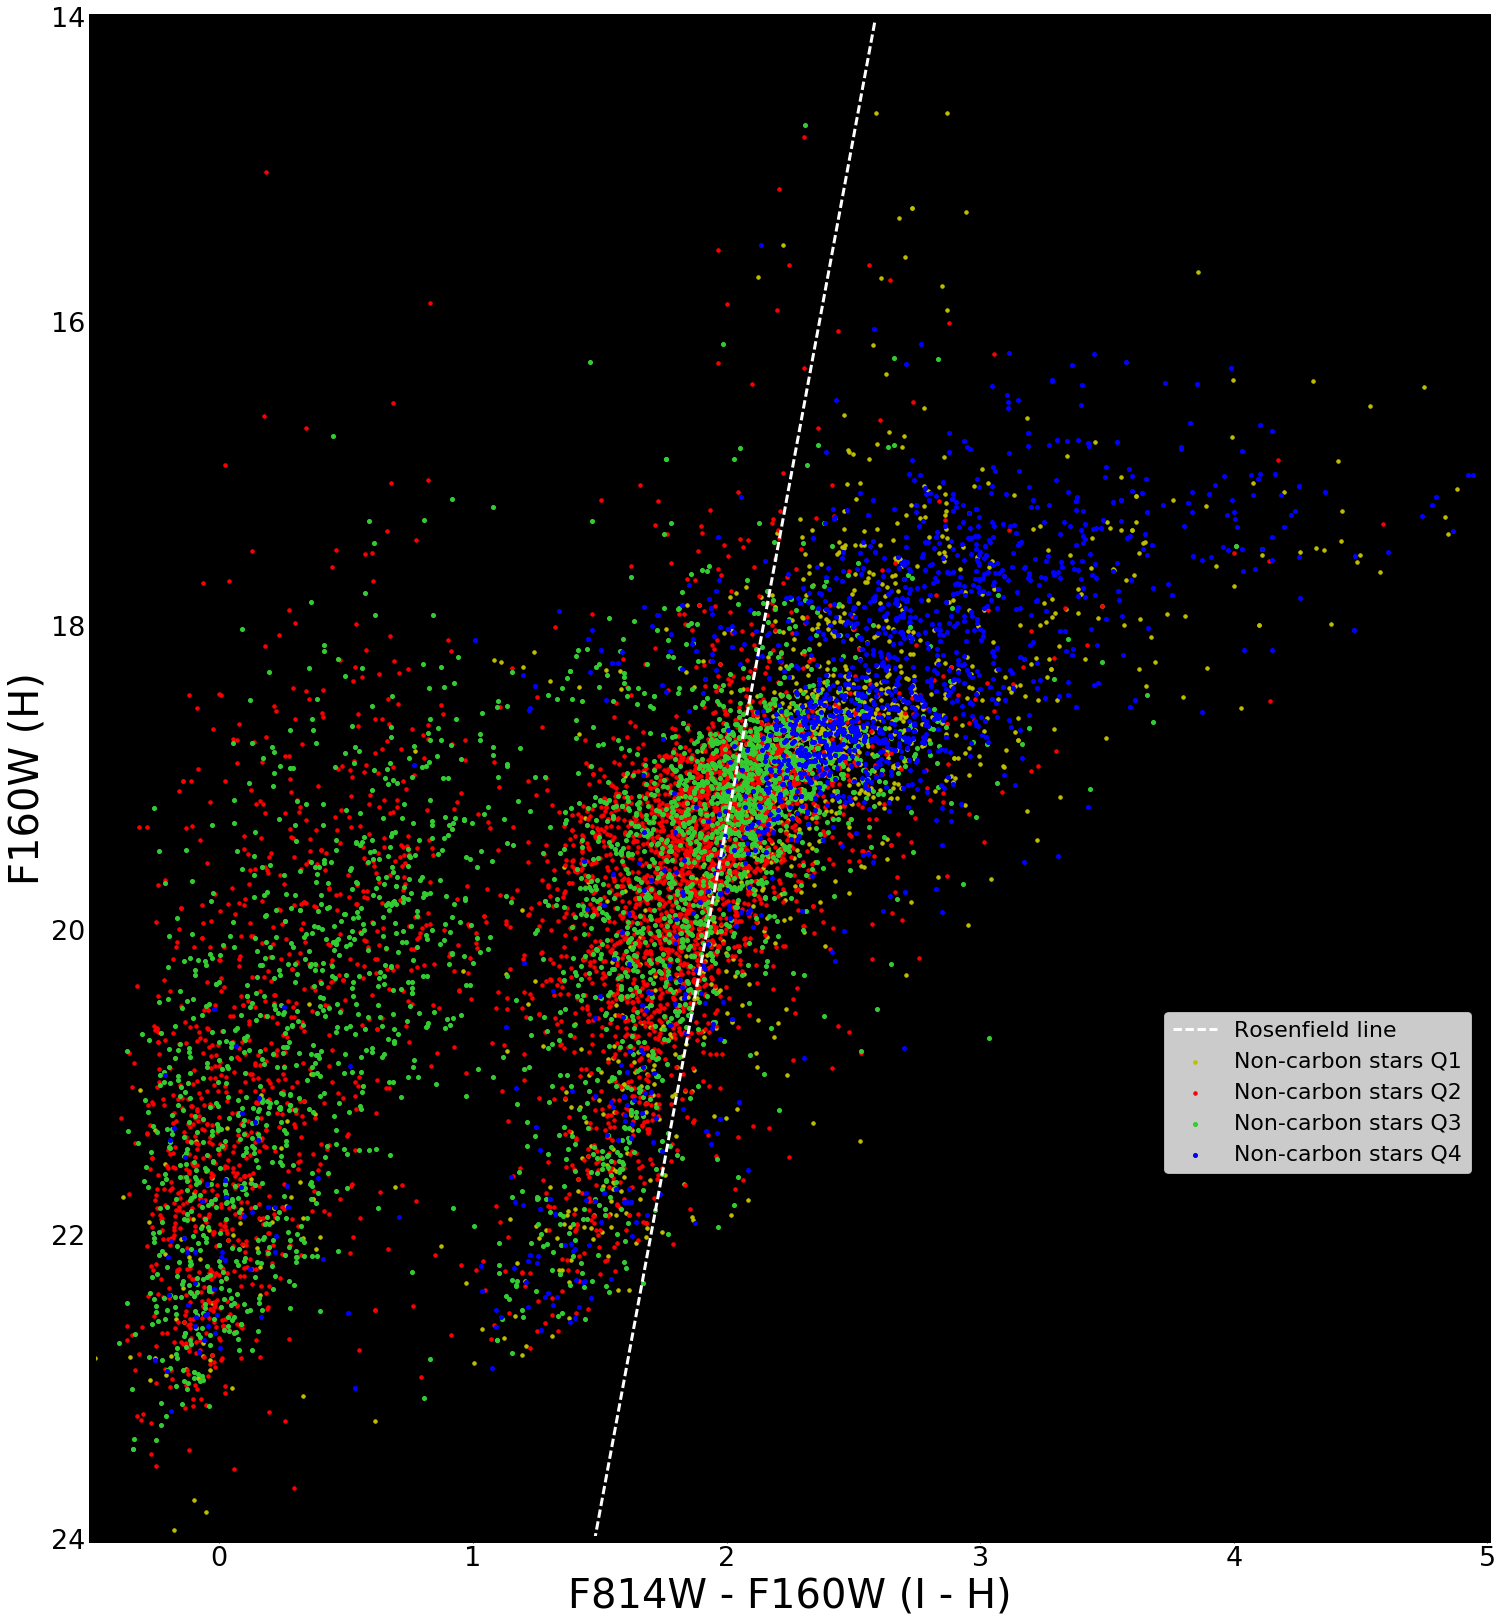

In [122]:
leFig = py.figure()
leAx = leFig.add_subplot(111, axisbg='black')

py.rcParams['figure.figsize'] = 25, 28

mm.cmd_plot2(data, oQ1, 12, 'y', label = 'Non-carbon stars Q1') #yellow, far right, Cstar, & some MS
mm.cmd_plot2(data, oQ2, 12, 'r', label = 'Non-carbon stars Q2') #red, RBG & MS
mm.cmd_plot2(data, oQ3, 16, 'limegreen', label = 'Non-carbon stars Q3') #green, tRGB & AGB
mm.cmd_plot2(data, oQ4, 16, 'b', label = 'Non-carbon stars Q4') #blue, tRGB & AGB left

#mm.cmd_plot2(data, allcarbon, 70, 'lime', label = 'Carbon stars') # carbon stars are GREEN
#mm.cmd_plot2(data, wNm, 70, 'b', label = 'Weak CN stars (secure)') #WEAK CN stars are BLUE


py.plot(xPhil, yPhil, color = 'white', linewidth = 3, linestyle = '--', label = 'Rosenfield line')

#bin1Path, bin2Path, bin3Path, bin4Path, bin5Path, bin6Path, bin7Path, bin8Path, bin9Path, bin10Path, bin11Path = mm.darrylPhilBin()

py.xlim(-0.5, 5)
py.ylim(24, 14)

leAx.set_xlabel('F814W - F160W (I - H)', fontsize = 40)
leAx.set_ylabel('F160W (H)', fontsize = 40)
py.legend(fontsize = 22, bbox_to_anchor=(0.897, 0.392),
           bbox_transform=py.gcf().transFigure)

leAx.tick_params(axis='x', labelsize=27)
leAx.tick_params(axis='y', labelsize=27)
for axis in ['top','bottom','left','right']:
    leAx.spines[axis].set_linewidth(7)


In [124]:
ofile = open(os.path.join(pathname, 'Others_Dict.txt'), 'w')
for i in others:
    ofile.write(str(i) + '          '+str(others_scale_Dict[i]) + '          '+ str(others_score_Dict[i])+'\n')
ofile.close()
    

NameError: name 'others_scale_Dict' is not defined

In [125]:
wfile = open(os.path.join(pathname, 'wNM_Dict.txt'), 'w')
for i in wNm:
    wfile.write(str(i) + '          '+str(wNm_scale_Dict[i]) + '          '+ str(wNm_score_Dict[i])+'\n')
wfile.close()
    

NameError: name 'wNm_scale_Dict' is not defined

In [126]:
cfile = open(os.path.join(pathname, 'allC_Dict.txt'), 'w')
for i in allcarbon:
    cfile.write(str(i) + '          '+str(allC_scale_Dict[i]) + '          '+ str(allC_score_Dict[i])+'\n')
cfile.close()
    

NameError: name 'allC_scale_Dict' is not defined

TypeError: 'numpy.float64' object is not iterable

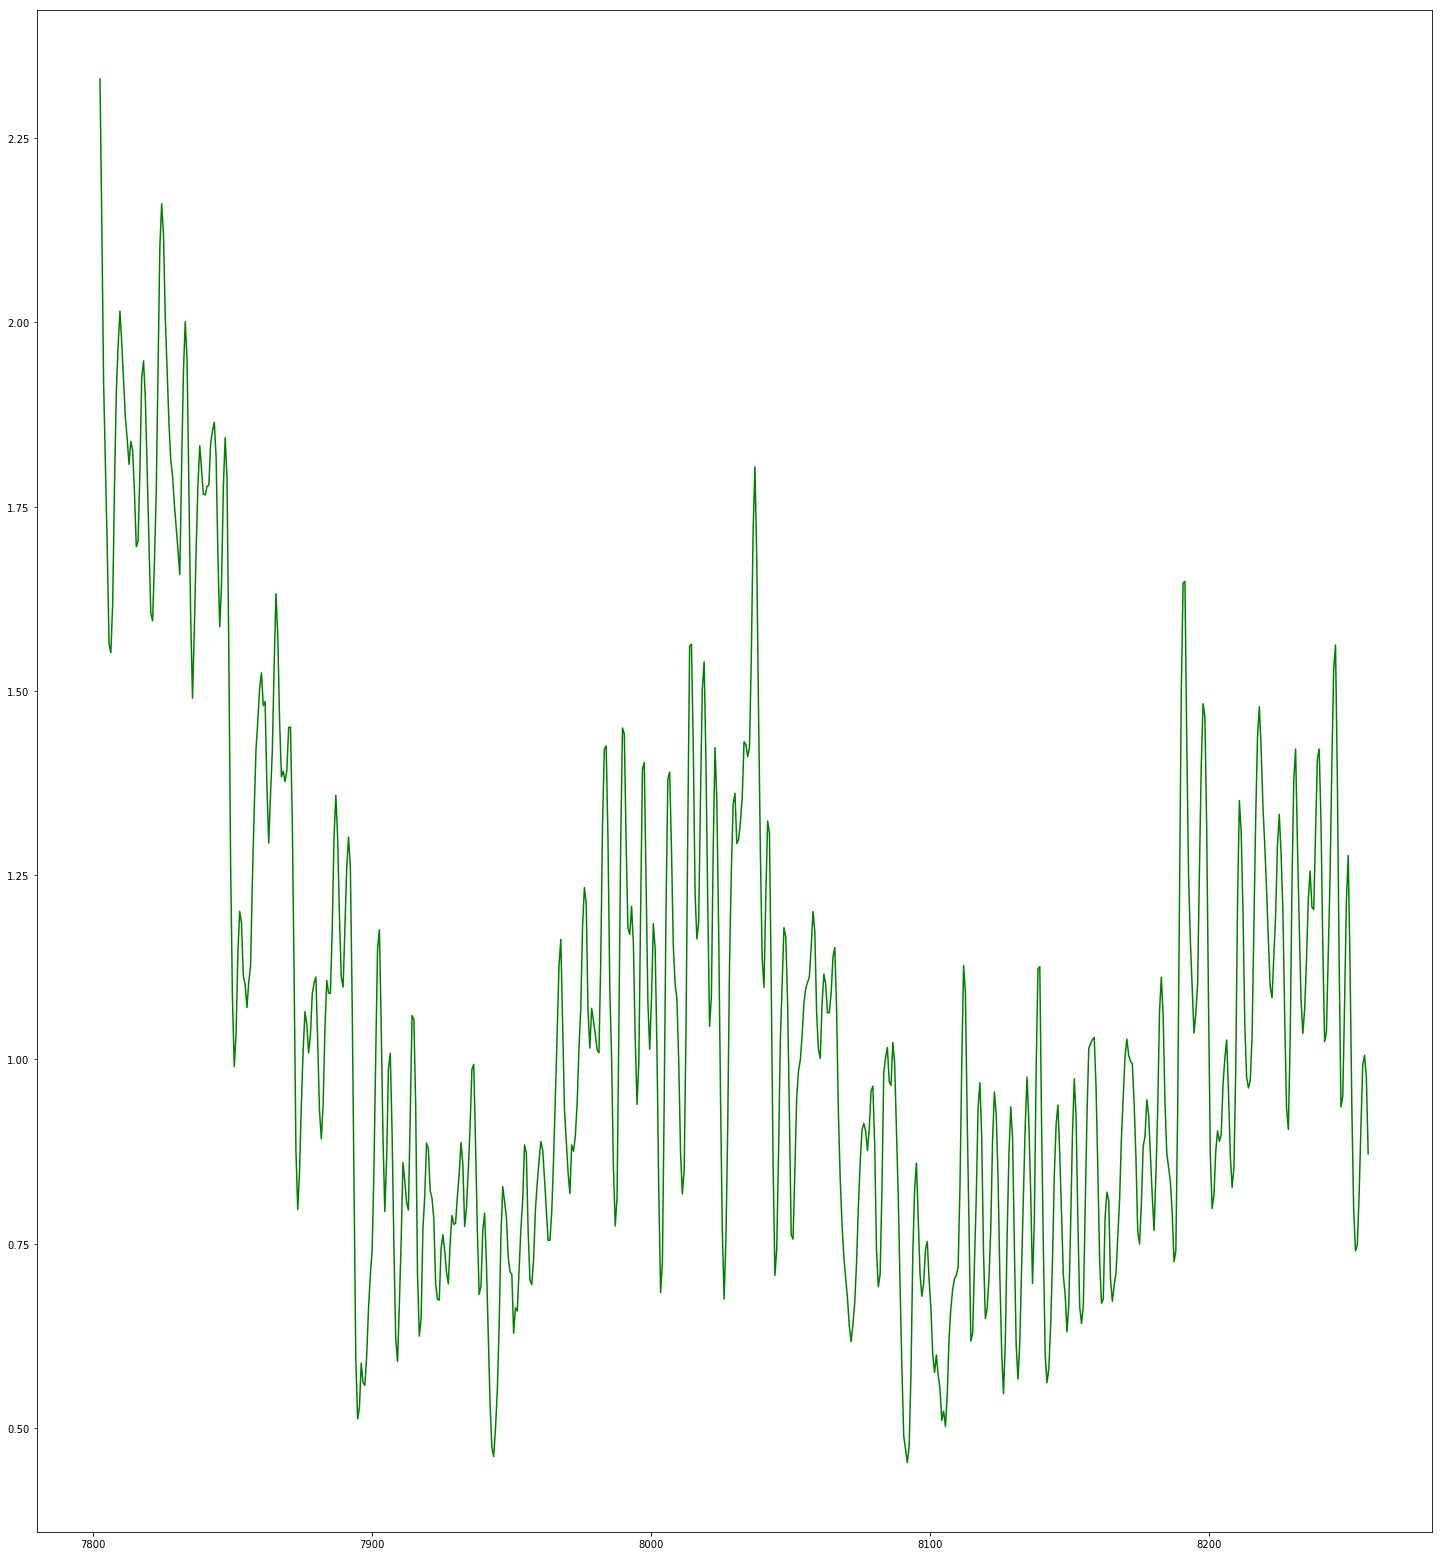

In [127]:
py.plot(wv, CtempSpec, color = "green")

scoree, spece = findScore(wNm[9], wNm_s_Dict, wNm_c_Dict)
py.plot(wv, spece + 1, color = "orange")

normSpece = convolve(normalizeStar(wNm[9]), gauss)
py.plot(wv, normSpece + 5, color = "blue")



In [128]:
sloop = 0

#py.plot(data['LBIN'][1][4000:8001], tempSpec, color = 'b')

def getMatchScore(testStar, Dict):
    #tempSpec = getTiltedSpec(Dict[testStar])
    testSpec, ivar = normalizeStar(testStar)
    sq_diff = np.square(np.subtract(testSpec, WtempSpec))
    weighted_diff = sq_diff*ivar
    div = len(testSpec[~np.isnan(testSpec)])
    total = np.nansum(weighted_diff)/div
    total = np.sqrt(total)
    total = total*10000
    return testSpec, total

def compareScore(array, Dict):
    testSpecDict = {}
    starScores ={}
    for testyStar in array:
        testStarSpec, score = getMatchScore(testyStar, Dict)
        testSpecDict[testyStar] = testStarSpec
        starScores[testyStar] = score
    #following line sorts keys based on their values and assigns to list called sortedDict
    #lower values (scores) are at the first part of the array
    sortedDict = sorted(starScores, key=lambda key: starScores[key])
    print()
    print("star ","|", "  score")
    print("--------------------")
    for i in sortedDict:
        print(i, "|", starScores[i])
    return testSpecDict, starScores, sortedDict

In [129]:
# Displays the sorted ranking of star rows based on their scores in whatever array 
def getCRanks(indices, sortedKeys, scores, Threshold):
    carbonRank = {}
    for i in indices:
        for k in range(len(sortedKeys)):
            if i == sortedKeys[k]:
                carbonRank[i] = k
    visualLowScore = sorted(carbonRank, key=lambda key: carbonRank[key])
    setWNM = set(indices)
    cutKeys = set(sortedKeys[:Threshold])  
    automatedLowScore = cutKeys.difference(set(visualLowScore))
    visualHighScore = setWNM.difference(set(visualLowScore))
    
    carbon_ranks = []
    for i in visualLowScore:
        if carbonRank[i] < Threshold:
            carbon_ranks.append(carbonRank[i])
            print(i, "|", carbonRank[i], "|",  scores[i])
    return visualLowScore, list(automatedLowScore), list(visualHighScore)



In [130]:
allStars_s_Dict = {}
for i in others:
    allStars_s_Dict[i] = others_s_DictW[i]

for i in wNm:
    allStars_s_Dict[i] = wNm_s_DictW[i]

for i in allcarbon:
    allStars_s_Dict[i] = allC_s_DictW[i]
    
print(len(allStars_s_Dict.keys()))

NameError: name 'others_s_DictW' is not defined

In [ ]:
# somewhat arbitrarily chosen list of 44 stars to test against the weak coaddition
# some from known marginal, strong, and weak populations
# others (23 of them) from noncarbon stars
carbon_tests = [33, 15952, 13585, 12226, 7276, 18011, 17921, 3316, 2918, 4211, 15586, 14788, 11920, 536, 19637, 16233, 15702, 17290, 9737, 3264, 3762, 12304, 20308, 24085, 24498, 24730, 21469, 2217, 23624, 22569, 23596, 21069, 23693, 24045, 21305, 21308, 21821, 21859, 24483, 20379, 20903, 24395, 20811, 23439]
carbon_tests = [i for i in carbon_tests if i not in outsiders]

In [ ]:
rand1Specs, rand1Scores, rand1SortedKeys = compareScore(carbon_tests, allStars_s_Dict)

In [ ]:
a, b, c = getCRanks(wNm, rand1SortedKeys, rand1Scores, 100)

In [ ]:
mm.cmd_plot2(data, others, s = 1, clr = 'k')

mm.cmd_plot2(data, c, clr = 'b')
#mm.cmd_plot2(data, a, clr = 'm')
mm.cmd_plot2(data, b, clr = 'r')
py.rcParams['figure.figsize'] = 13,11


py.xlim(-1, 5)
py.ylim(25, 14)


In [ ]:

leSpecs, leScores, leSortedKeys = compareScore(others, allStars_s_Dict)
#note the 0.0 value for star 22283 
#this is because there are NO VALUES in the spectra of star 22283

In [ ]:
d, e, f = getCRanks(wNm, leSortedKeys, leScores, 50)

In [ ]:
mm.cmd_plot2(data, f, clr = 'b')
#mm.cmd_plot2(data, d, clr = 'm')
mm.cmd_plot2(data, e, clr = 'r')
mm.cmd_plot2(data, others, s = 1, clr = 'k')
py.rcParams['figure.figsize'] = 13,11


py.xlim(-1, 5)
py.ylim(25, 14)


In [ ]:
total = list(range(data.size))
mct6 = total[19748:]
mct6.remove(22283)
mct6Specs, mct6Scores, mct6SortedKeys = compareScore(mct6)
#note the 0.0 value for star 22283 
#this is because there are NO VALUES in the spectra of star 22283

In [ ]:
getCRanks(wNm, mct6SortedKeys, mct6Scores, 50)

In [ ]:
#mm.cmd_plot2(data, d, clr = 'm')
mm.cmd_plot2(data, e, clr = 'r')
mm.cmd_plot2(data, f, clr = 'b')
mm.cmd_plot2(data, others, s = 1, clr = 'k')
py.rcParams['figure.figsize'] = 13,11


py.xlim(-1, 5)
py.ylim(25, 14)


In [ ]:
for i in range(len(mct6SortedKeys)):, 
    print('rank', i, mct6SortedKeys[i])

In [ ]:
m = (19 - -52.965)/(2.03045-10)     # Slope of Phil's line, derived from the two points on A^3's plot
xPhil = np.arange(1, 3, .01)
yPhil = m*xPhil - 2.0345*m + 19 

In [ ]:
py.rcParams['figure.figsize'] = 13,11

mm.cmd_plot2(data, others, 0.5, 'k', label = 'unidentified NonCarbon')
mm.cmd_plot2(data, wNm, 13, 'b', label = 'Identified Weak CN')


allthings = list(range(5295))
for i in carbon_ranks:
    allthings.remove(i)
#print(allthings)
nc_lowScore = [i for i in allthings if i < 150]
print(nc_lowScore)
#print(len(nc_lowScore))

for p in nc_lowScore:
    if p == 13:
        mm.cmd_plot2(data, mct6SortedKeys[p], 20, 'r', label = "NonC-star w/ low score")
    else:
        mm.cmd_plot2(data, mct6SortedKeys[p], 20, 'r')


py.plot(xPhil, yPhil, color = 'k', linewidth = 3, linestyle = '--', label = 'Rosenfield line')


bin1Points = [[3.2, 19.], [3.50, 16.5], [4.999, 17], [4.9, 18.2]]
mm.polygon(bin1Points, 'brown', '1')
bin1Path = path.Path(bin1Points)

bin2Points = [[2.99, 16.5], [2.685, 19.2], [3.2, 19.], [3.50, 16.5]]
mm.polygon(bin2Points, 'red', '2')
bin2Path = path.Path(bin2Points)
# mask = bin5.contains_point([1,0])

bin3Points = [[2.814, 15], [3.1506, 15], [2.785, 18.3], [2.442, 18.3]]
mm.polygon(bin3Points, 'orange', '3')
bin3Path = path.Path(bin3Points)

bin4Points = [[2.442, 18.3], [2.785, 18.3], [2.685, 19.2], [2.31, 19.5]]
mm.polygon(bin4Points, 'yellow', '4')
bin4Path = path.Path(bin4Points)

bin5Points = [[2.477468, 15], [2.814, 15], [2.442, 18.3], [2.079, 18.6]]
mm.polygon(bin5Points, 'g', '5')
bin5Path = path.Path(bin5Points)

bin6Points = [[2.079, 18.6], [2.442, 18.3], [2.31, 19.5], [1.8795, 20.4]]
mm.polygon(bin6Points, 'b', '6')
bin6Path = path.Path(bin6Points)

bin7Points = [[1.4,19.15],[2.079,18.6],[2.4996,14.8],[1.82,15.5]]
mm.polygon(bin7Points, 'indigo', '7 ')
bin7Path = path.Path(bin7Points)

bin8Points = [[1.4,19.15],[2.079,18.6],[1.6524,22.45],[1.2,22.8]]
mm.polygon(bin8Points, 'violet', '8')
bin8Path = path.Path(bin8Points)


py.xlim(-1, 5)
py.ylim(25, 14)

py.legend(bbox_to_anchor=(0.337, 0.903),
           bbox_transform=py.gcf().transFigure)

In [ ]:
py.rcParams['figure.figsize'] = 20,20
mm.cmd_plot2(data, others, 1, 'k', label = 'Non-carbon stars') #NONCARBON stars are BLACK and smaller
mm.cmd_plot2(data, 24912, 50, 'r') #EXTREME carbon stars are RED
mm.cmd_plot2(data, wNm, 30, 'b', label = ) #EXTREME carbon stars are RED



py.xlim(-1, 5)
py.ylim(25, 14)

py.xlabel('F814W - F160W (I - H)')
py.ylabel('F160W (H)')
py.legend()

In [ ]:
py.rcParams['figure.figsize'] = 35,16

py.xlim(6500, 9300)
py.ylim(-1, 2)
py.plot(data['LBIN'][1][lowerThresh:upperThresh +1], tempSpec, color = 'r')
#py.plot(data['LBIN'][1][lowerThresh:upperThresh+1], mct6Specs[20291], color = 'b')
#py.plot(data['LBIN'][1][lowerThresh:upperThresh+1], mct6Specs[23161], color = 'g')
#py.plot(data['LBIN'][1][lowerThresh:upperThresh+1], rand1Specs[21821], color = 'purple')
#py.plot(data['LBIN'][1][lowerThresh:upperThresh+1], rand1Specs[0], color = 'darkorange')

In [ ]:
py.plot(data['LBIN'][0], data['SPEC'][20267], color = 'g')
py.rcParams['figure.figsize'] = 40, 15
